In [111]:
import pandas as pd
import datetime
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.lines as line

import seaborn as sns

import statsmodels as sm

from math import sqrt

from scipy import stats
from scipy.odr import *
from scipy.integrate import odeint
from scipy.optimize import curve_fit

%matplotlib inline

In [112]:
data=pd.read_csv('dpc-covid19-ita-andamento-nazionale.csv')
data['data'] = pd.to_datetime(data['data'])
data['data'] = data['data'].dt.strftime('%d/%m')
data.index=data['data']
data['totale_attualmente_positivi']=data['totale_attualmente_positivi']/60483973
data.drop('data',axis=1)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
data,,,,,,,,,,,,,
24/02,ITA,101,26,127,94,0.000004,221,1,7,229,4324,NaN,NaN
25/02,ITA,114,35,150,162,0.000005,90,1,10,322,8623,NaN,NaN
26/02,ITA,128,36,164,221,0.000006,74,3,12,400,9587,NaN,NaN
27/02,ITA,248,56,304,284,0.000010,203,45,17,650,12014,NaN,NaN
28/02,ITA,345,64,409,412,0.000014,233,46,21,888,15695,NaN,NaN
29/02,ITA,401,105,506,543,0.000017,228,50,29,1128,18661,NaN,NaN
01/03,ITA,639,140,779,798,0.000026,528,83,34,1694,21127,NaN,NaN
02/03,ITA,742,166,908,927,0.000030,258,149,52,2036,23345,NaN,NaN
03/03,ITA,1034,229,1263,1000,0.000037,428,160,79,2502,25856,NaN,NaN


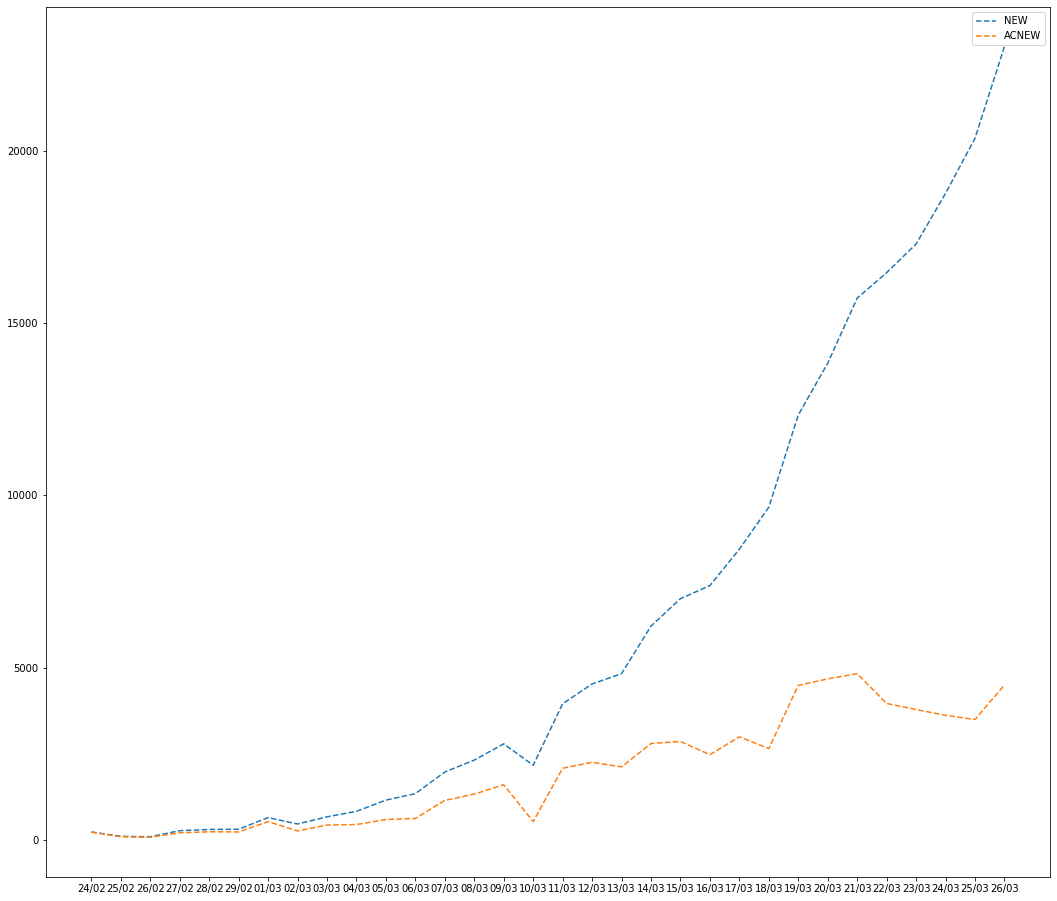

In [113]:
fig=plt.figure(figsize=(18,16))
new=fig.add_subplot(1,1,1)
#nooooooooooooooooo scemoooooo
new.plot(data.index,data['nuovi_attualmente_positivi']+data['dimessi_guariti']+data['deceduti'],'--',label='NEW')
new.plot(data.index,data['nuovi_attualmente_positivi'],'--',label='ACNEW')
new.legend()

#grw=fig.add_subplot(2,2,3)
#grw.plot(data.index,data['GRW'],'--',label='GRW')
#grw.plot(data.index,data['ACGRW'],'--',label='ACGRW')
#l = line.Line2D([13,25], [1,1])
#grw.add_line(l)
#grw.legend()

In [123]:
t=data.index.to_series(index=range(data.index.size))
t_fit=t[18:]
t_fit=range(t_fit.size)
t=range(t.size+30) 
t_fit
base = datetime.datetime.strptime('13/03/2020','%d/%m/%Y')
base2 = datetime.datetime.strptime('24/02/2020','%d/%m/%Y')
dlist =[base2 + datetime.timedelta(days=x) for x in range(60)]
mdate_list=[x for x in dlist if x<(datetime.datetime.today()-timedelta(1))]
date_list = [base + datetime.timedelta(days=x) for x in range(len(t))]
date_list

NameError: name 'timedelta' is not defined

In [121]:
trans = 2.3 #rateo di trasmissione
recov = 0.6 #rateo di recovery
tmax = 60#numero di giorni fittizio
totpos=data['totale_attualmente_positivi']
#initial conditions
sstart = 1-totpos['13/03']
rstart = 0
istart = totpos['13/03']
# time points
                      
#fit base
def modelI(t,trans,recov):
# function that returns dy/dt
    def model(y,t):
        S=y[0]
        I=y[1]
        R=y[2]
        dS = -trans*S*I
        dI = trans*S*I-recov*I
        dR = recov*I
        return [dS,dI,dR]
    y0=[sstart,istart,rstart]
    # solve ODE
    y = odeint(model,y0,t)
    return y[:,1]

ValueError: x and y must have same first dimension, but have shapes (33,) and (32,)

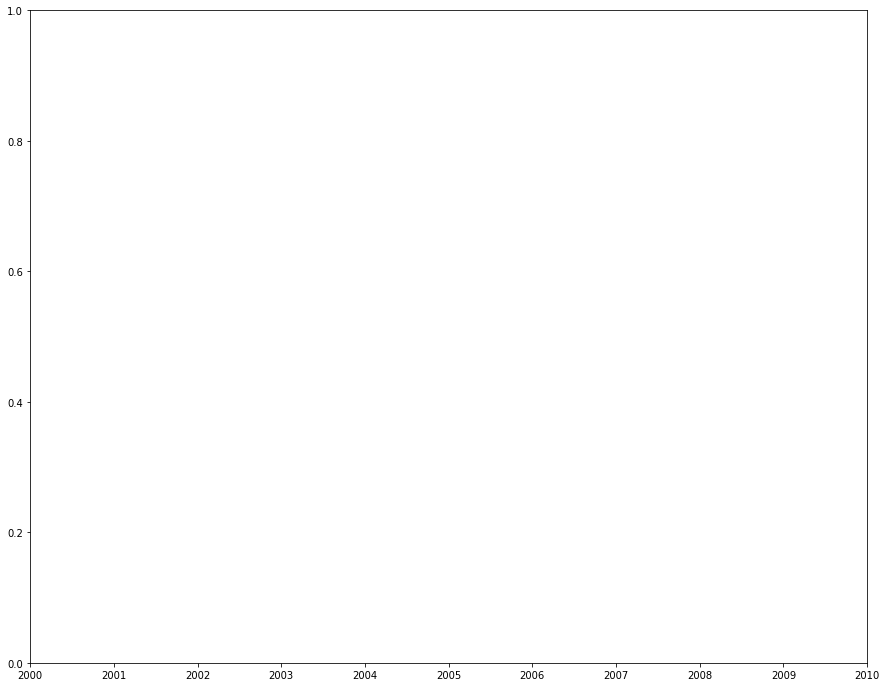

In [119]:
p,cov=curve_fit(modelI,t_fit,totpos['13/03':])
trans,recov=p
fit=modelI(t,trans,recov)
fig2=plt.figure(figsize=(15,12))
tot=fig2.add_subplot(1,1,1)
tot.plot(mdate_list,data['totale_attualmente_positivi']*60483973+data['dimessi_guariti']+data['deceduti'],'--',label='NEW')
tot.plot(mdate_list,data['totale_attualmente_positivi']*60483973,'--',label='ACNEW')
tot.plot(date_list,fit*60483973,'k--',label='Model')
tot.set_xlabel('Date')
tot.set_ylabel('Number of people')


In [44]:
p

array([-3.54111908, -3.68761543])